# Do attractive Redditors get more upvotes?
### Group 17: Jack Silk (jsilk13), **David Haas** (dhaas6), **Spencer Mullinix** (mullisd1)

### Is there a correlation between the attractiveness of the redditor and the number of upvotes they get?
We believe that the higher the physical attractiveness of the redditor is, the more upvotes they will receive.  Whether it is conscious or subconscious, we think that to some degree, users decide whether to upvote a post or not based on the attractivness of the poster.

### How do we estimate the attractiveness of a Reddit user?
We use a facial recognition algorithm to apply a rating of physical attractiveness to the user.  Dlib's facial recognition tool creates a vector of 128 values based on the features of a person's face. We use these encodings as inputs to two machine learning algorithms which attempt to predict how attractive someone is.

# Quantitative Analysis

In [6]:
# Machine learning
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression

# Data science
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn

# Other
import pickle
import os

## Loading models and data
Using our code from last week (it's a long file that can be found [here](https://github.com/davidhaas6/attractiveness-regression/blob/master/scraper/scrape_encode.py)), we ran a script on a Google Cloud VM for about 4 days to collect over 100k samples (posts) from 3 different subreddits. Our first step is to load them into variables from the disk.

[Last week](https://github.com/davidhaas6/attractiveness-regression/blob/master/phase2.ipynb), we trained models on the SCUT-FBP5500_v2 dataset. We must now load back in those trained models to perform analysis.

In [7]:
# Load in the scraped data from reddit
pic_encodings, pic_metadata = np.load("encodings/pics_1425-050720.pkl", allow_pickle=True)
selfie_encodings, selfie_metadata = np.load("encodings/selfies_1647-050720.pkl", allow_pickle=True)
roastme_encodings, roast_metadata = np.load("encodings/roastme_1901-050820.pkl", allow_pickle=True)

In [8]:
# Train attractiveness rating predictors

# SCUT_encodings = np.load('SCUT-encodings.npy')
# SCUT_labels = np.load('SCUT-labels.npy')

# Load and train Neural Network
# network = MLPRegressor(validation_fraction = 0, solver='adam', max_iter= 1000).fit(SCUT_encodings, SCUT_labels)

# Load and train linear regression model
# linreg = LinearRegression().fit(SCUT_encodings, SCUT_labels)

In [9]:
# Load machine learning models in from pickles for speed
network = pickle.load(open('nn.pkl', 'rb'))
linreg = pickle.load(open('lr.pkl', 'rb'))

## Run ML Algorithms and Build DataFrames
Now that we have all of our data loaded into memory, we must use our machine learning algorithms to predict the attractiveness of each of our samples; this is done in the following cell.

After that, let's combine our attractiveness ratings with the upvote counts we scraped from each post into a DataFrame so we can analyze it more efficiently

In [10]:
# Predict ratings with linear regression model
lr_pic_ratings = linreg.predict(pic_encodings)
lr_selfie_ratings = linreg.predict(selfie_encodings)
lr_roastme_ratings =  linreg.predict(roastme_encodings)

# Predict ratings with Neural Network
nn_pic_ratings = network.predict(pic_encodings)
nn_selfie_ratings = network.predict(selfie_encodings)
nn_roastme_ratings = network.predict(roastme_encodings)

In [42]:
# Build dataframes to combine attractiveness and upvotes
scores = lambda metadata: list(zip(*metadata))[2]  # get scores from metedata
pics_data = np.vstack((scores(pic_metadata), lr_pic_ratings, nn_pic_ratings)).T
selfies_data = np.vstack((scores(selfie_metadata), lr_selfie_ratings, nn_selfie_ratings)).T
roastme_data = np.vstack((scores(roast_metadata), lr_roastme_ratings, nn_roastme_ratings)).T

column_labels = ['Post Score', 'Lin Regr. Rating', 'NN Rating']
pics = pd.DataFrame(data=pics_data, columns=column_labels)
selfies = pd.DataFrame(data=selfies_data, columns=column_labels)
roastme = pd.DataFrame(data=roastme_data, columns=column_labels)

print("/r/roastme DataFrame Head")
roastme.head()

/r/roastme DataFrame Head


,Post Score,Lin Regr. Rating,NN Rating
0,1.0,3.535434,3.644987
1,1.0,2.474639,1.073011
2,1.0,3.381227,2.765357
3,1.0,3.629842,3.688608
4,1.0,3.682503,3.398511


## Preliminary Visualizations
So far, we have our scraped data loaded in (facial encodings, reddit post scores), we calculated the predicted attractiveness for all our samples, and we formatted that data into Pandas dataframes for convenience.

Now, let's run some preliminary visualizations to see generally what our data really looks like.


### Attractiveness Distribution
First, let's check our assumptions that attractiveness will generally be normally distributed throughout our dataset.

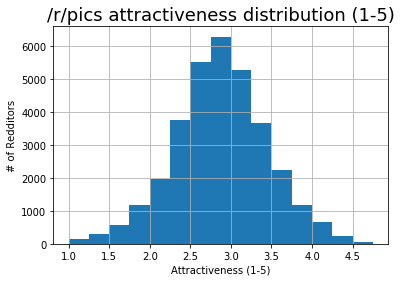

In [38]:
attr_bins = np.arange(1,5, .25)
pics['NN Rating'].hist(bins=attr_bins)
plt.xlabel("Attractiveness (1-5)")
plt.ylabel("# of Redditors")
plt.title("/r/pics attractiveness distribution (1-5)", size=18);

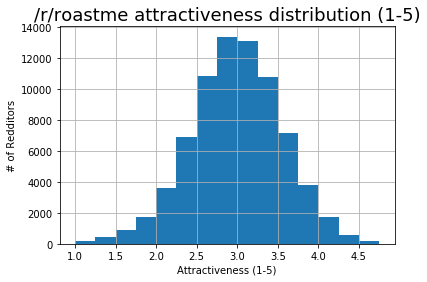

In [37]:
roastme['NN Rating'].hist(bins=attr_bins)
plt.xlabel("Attractiveness (1-5)")
plt.ylabel("# of Redditors")
plt.title("/r/roastme attractiveness distribution (1-5)", size=18);

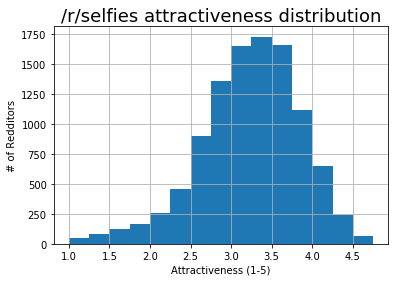

In [14]:
selfies['NN Rating'].hist(bins=attr_bins)
plt.xlabel("Attractiveness (1-5)")
plt.ylabel("# of Redditors")
plt.title("/r/selfies attractiveness distribution", size=18);

### Attractiveness Distribution Analysis
The attractiveness of /r/roastme and /r/pics strongly resembles a normal distribution, which is good. Interestingly enough, the attractiveness distribution of /r/selfies seems to be skewed towards higher attractiveness. Perhaps more attractive people are more likely to post a selfie of themself?

## Correlation
Now lets look at what we really care about: do more attractive people get more upvotes. i.e. is there a correlation between attractiveness and post score for our samples?

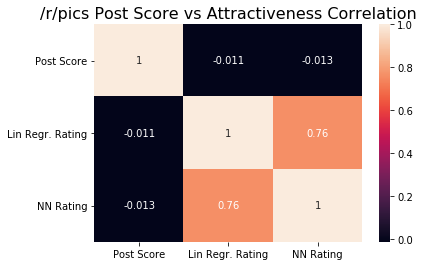

In [43]:
seaborn.heatmap(pics.corr(), annot=True)
plt.title('/r/pics Post Score vs Attractiveness Correlation', size=16);

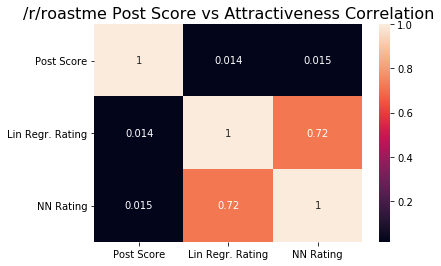

In [44]:
seaborn.heatmap(roastme.corr(), annot=True)
plt.title('/r/roastme Post Score vs Attractiveness Correlation', size=16);

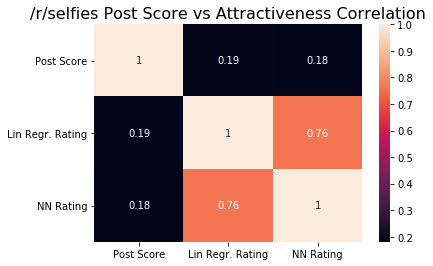

In [51]:
seaborn.heatmap(selfies.corr(), annot=True)
plt.title('/r/selfies Post Score vs Attractiveness Correlation', size=16);

### Correlation analysis
What we are looking at in these graphs is the first row/column: it shows the correlation between post score and the attractiveness ratings each predictor assigned the samples. Interstingly enough, there is not strong correlation between the scores and the attractiveness ratings. 

However, it's interesting to see that /r/selfies had a correlation coefficient ~20 times higher than the other two subreddits. Combined with that subreddit's skew towards more attractive posters, perhaps one could say that /r/selfies values beauty more than the other two subreddits?

## Further Visualization

Below are a few more visualizations.  The first scatter plot compares the NN Rating to the Post Score for our samples.  The second plot compares the errors and attempts to fit a regression line for the samples.  LEt's see what this looks like.

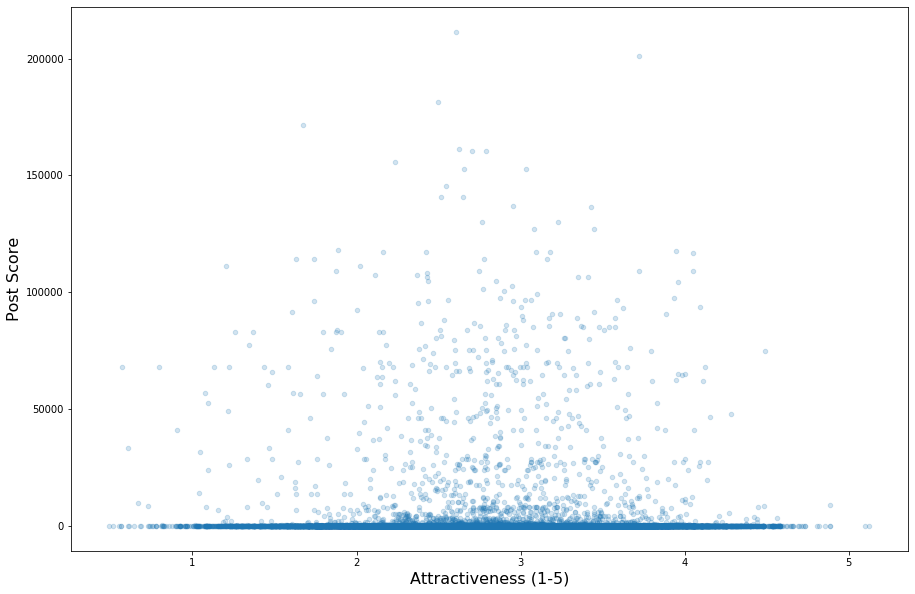

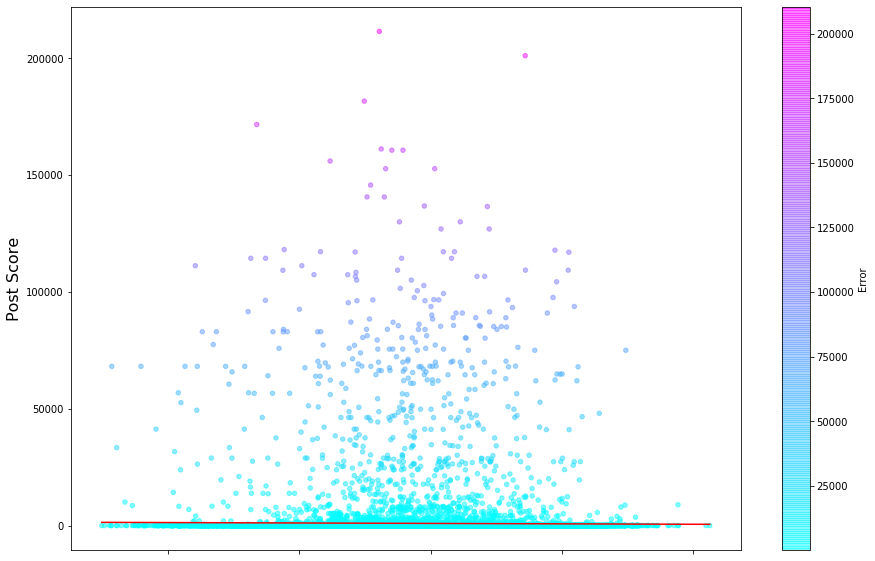

In [28]:
#VISUALIZATIONS FOR PIC
import matplotlib

#Scatter with Karma as Size
KarmaSize = pics.plot.scatter(x='NN Rating', y='Post Score', figsize=(15,10), alpha=.2)
KarmaSize.set_xlabel("Attractiveness (1-5)", fontsize=16)
KarmaSize.set_ylabel("Post Score", fontsize=16)

#Correlation
mny = np.mean(pics['Post Score'])
mnx = np.mean(pics['NN Rating'])
r = np.sum((pics['NN Rating'] - mnx) * (pics['Post Score'] - mny)) / (np.sqrt(np.sum(np.square(pics['NN Rating'] - mnx))) * (np.sqrt(np.sum(np.square(pics['Post Score'] - mny)))))

#Regression Parameters
[A, V] = np.polyfit(pics['NN Rating'], pics['Post Score'], 1)
Answer3 = (A, V)

#Regression Error
def Residuals(row):
    return( row['Post Score'] - ((A * row['NN Rating']) + V))

pics['Error'] = pics.apply(lambda row: Residuals(row), axis=1)

#Regression & Error Plot
pics['Error'] = pics['Error'].abs()
sc = pics.plot.scatter(x='NN Rating', y='Post Score', c='Error', colormap=plt.cm.cool, figsize=(15,10), alpha=.5)
sc.set_xlabel("Attractiveness (1-5)", fontsize=16)
sc.set_ylabel("Post Score", fontsize=16)
sc.add_line(matplotlib.lines.Line2D([pics['NN Rating'].min(), pics['NN Rating'].max()], 
                                    [A * pics['NN Rating'].min() + V, A * pics['NN Rating'].max() + V],
                                    color='Red'))

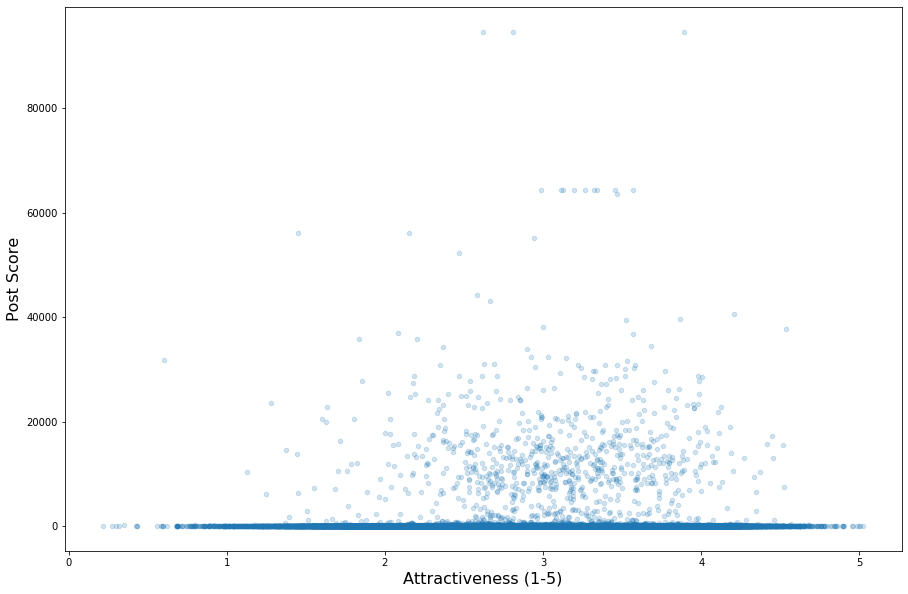

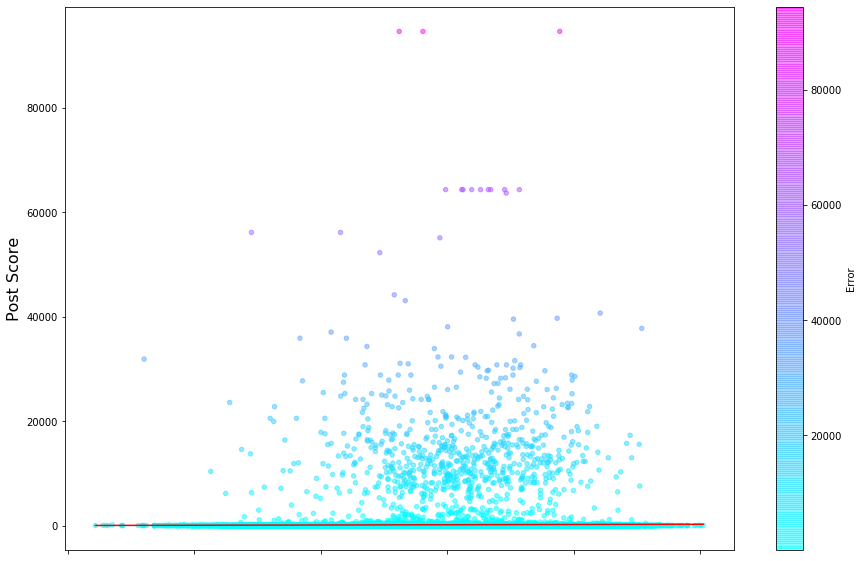

In [31]:
#VISUALIZATIONS FOR ROASTME

#Scatter with Karma as Size
KarmaSize = roastme.plot.scatter(x='NN Rating', y='Post Score', figsize=(15,10), alpha=.2)
KarmaSize.set_xlabel("Attractiveness (1-5)", fontsize=16)
KarmaSize.set_ylabel("Post Score", fontsize=16)


#Correlation
mny = np.mean(roastme['Post Score'])
mnx = np.mean(roastme['NN Rating'])
r = np.sum((roastme['NN Rating'] - mnx) * (roastme['Post Score'] - mny)) / (np.sqrt(np.sum(np.square(roastme['NN Rating'] - mnx))) * (np.sqrt(np.sum(np.square(roastme['Post Score'] - mny)))))

#Regression Parameters
[A, V] = np.polyfit(roastme['NN Rating'], roastme['Post Score'], 1)
Answer3 = (A, V)

#Regression Error
def Residuals(row):
    return( row['Post Score'] - ((A * row['NN Rating']) + V))

roastme['Error'] = roastme.apply(lambda row: Residuals(row), axis=1)

#Regression & Error Plot
roastme['Error'] = roastme['Error'].abs()
sc = roastme.plot.scatter(x='NN Rating', y='Post Score', c='Error', colormap=plt.cm.cool, figsize=(15,10), alpha=.5)
sc.set_xlabel("Attractiveness (1-5)", fontsize=16)
sc.set_ylabel("Post Score", fontsize=16)
sc.add_line(matplotlib.lines.Line2D([roastme['NN Rating'].min(), roastme['NN Rating'].max()], 
                                    [A * roastme['NN Rating'].min() + V, A * roastme['NN Rating'].max() + V],
                                    color='Red'))

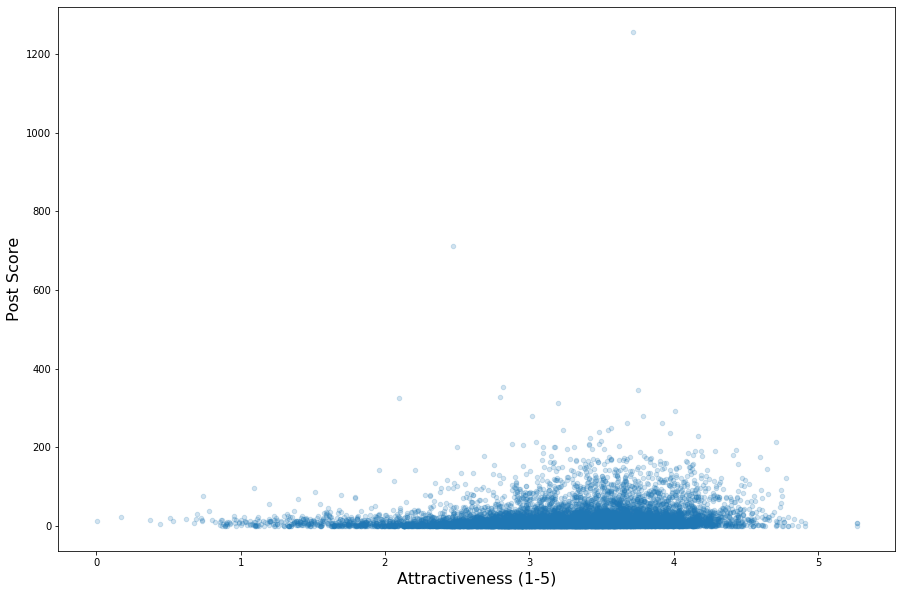

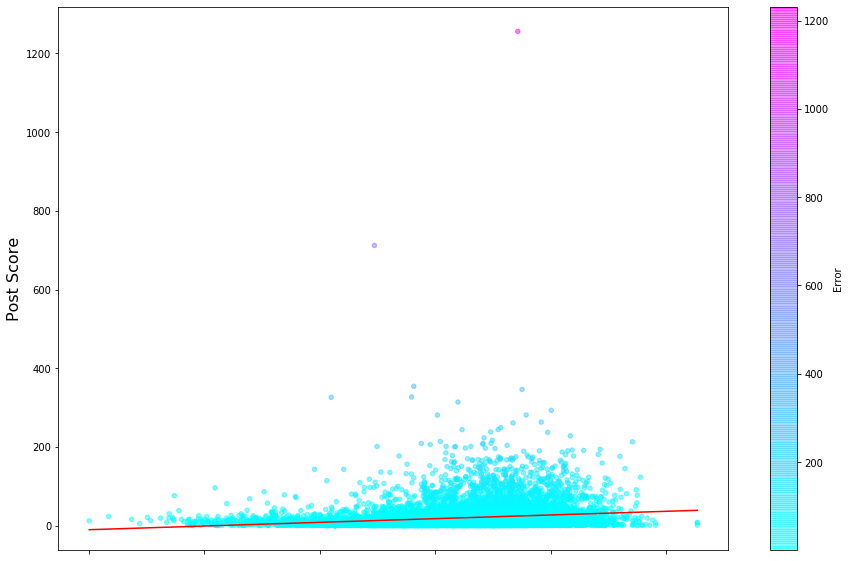

In [32]:
#VISUALIZATIONS FOR SELFIES

#Scatter with Karma as Size
KarmaSize = selfies.plot.scatter(x='NN Rating', y='Post Score', figsize=(15,10), alpha=.2)
KarmaSize.set_xlabel("Attractiveness (1-5)", fontsize=16)
KarmaSize.set_ylabel("Post Score", fontsize=16)


#Correlation
mny = np.mean(selfies['Post Score'])
mnx = np.mean(selfies['NN Rating'])
r = np.sum((selfies['NN Rating'] - mnx) * (selfies['Post Score'] - mny)) / (np.sqrt(np.sum(np.square(selfies['NN Rating'] - mnx))) * (np.sqrt(np.sum(np.square(selfies['Post Score'] - mny)))))

#Regression Parameters
[A, V] = np.polyfit(selfies['NN Rating'], selfies['Post Score'], 1)
Answer3 = (A, V)

#Regression Error
def Residuals(row):
    return( row['Post Score'] - ((A * row['NN Rating']) + V))

selfies['Error'] = selfies.apply(lambda row: Residuals(row), axis=1)

#Regression & Error Plot
selfies['Error'] = selfies['Error'].abs()
sc = selfies.plot.scatter(x='NN Rating', y='Post Score', c='Error', colormap=plt.cm.cool, figsize=(15,10), alpha=.5)
sc.set_xlabel("Attractiveness (1-5)", fontsize=16)
sc.set_ylabel("Post Score", fontsize=16)
sc.add_line(matplotlib.lines.Line2D([selfies['NN Rating'].min(), selfies['NN Rating'].max()], 
                                    [A * selfies['NN Rating'].min() + V, A * selfies['NN Rating'].max() + V],
                                    color='Red'))

### Further Visualization Analysis
It appears that the /r/selfies data is the only sample that shows a positive trend.  This could be explained by the fact that selfie posts, by nature, are pictures of the user's face, which is what the attractiveness rating is based on.  The plots for /r/roastme and /r/pics do not show a clear relationship between attractiveness and post score.  In fact, the /r/roastme data appears to have a slightly negative trend.  

# Conclusions

With an average Pearson correlation of 0.07 between score and attractiveness, we can definitely say that post score is not correlated with how our models define attractiveness. 

The primaty limitation of our research is that we utilized a machine learning model to estimate attractiveness. While we did run cross-validation experiments on our models in phase 2, and we do believe them to be generally accurate, the nature of the models themselve add noise to our data.

## Credit
**David Haas**: Data gathering and parsing, linear regression model, correlation analysis, some visualization.

**Spencer Mullinix**:

**Jack Silk**: Visualization and correlation analysis